In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = ['apple','banana','beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot',
                'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant','garlic',
                'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon','lettuce','mango', 'onion', 'orange','paprika', 'pear',
                 'peas','pineapple', 'pomegranate','potato','raddish','soy beans','spinach','sweetcorn', 'sweetpotato','tomato','turnip','watermelon']



set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output 

In [4]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 36]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

#### Notice how only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

In [5]:
# Setup directory paths to train and test images
train_dir = r'C:\Users\User\Desktop\VisionClassification\dataset\train'
test_dir = r'C:\Users\User\Desktop\VisionClassification\dataset\test'

Remember, if you're going to use a pretrained model, it's generally important to ensure your own custom data is transformed/formatted in the same way the data the original model was trained on.

In [6]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## And now we've got transforms ready, we can turn our images into DataLoaders using the create_dataloaders()

In [29]:
import os
class_names = os.listdir(train_dir)
print(class_names)

['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


In [7]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [8]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [32]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=20,
                                      device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4030 | train_acc: 0.6793 | test_loss: 0.4792 | test_acc: 0.8854
Epoch: 2 | train_loss: 0.5310 | train_acc: 0.8569 | test_loss: 0.3221 | test_acc: 0.8984
Epoch: 3 | train_loss: 0.3941 | train_acc: 0.8907 | test_loss: 0.2646 | test_acc: 0.9193
Epoch: 4 | train_loss: 0.3181 | train_acc: 0.9073 | test_loss: 0.2466 | test_acc: 0.9245
Epoch: 5 | train_loss: 0.2693 | train_acc: 0.9296 | test_loss: 0.2164 | test_acc: 0.9375
Epoch: 6 | train_loss: 0.2287 | train_acc: 0.9416 | test_loss: 0.2164 | test_acc: 0.9193
Epoch: 7 | train_loss: 0.2042 | train_acc: 0.9467 | test_loss: 0.1913 | test_acc: 0.9453
Epoch: 8 | train_loss: 0.1806 | train_acc: 0.9522 | test_loss: 0.1826 | test_acc: 0.9531
Epoch: 9 | train_loss: 0.1651 | train_acc: 0.9563 | test_loss: 0.1830 | test_acc: 0.9479
Epoch: 10 | train_loss: 0.1517 | train_acc: 0.9605 | test_loss: 0.1716 | test_acc: 0.9583
Epoch: 11 | train_loss: 0.1399 | train_acc: 0.9662 | test_loss: 0.1682 | test_acc: 0.9479
Epoch: 12 | train_l

pretrained ViT performed far better than our custom ViT model trained from scratch (in the same amount of time).


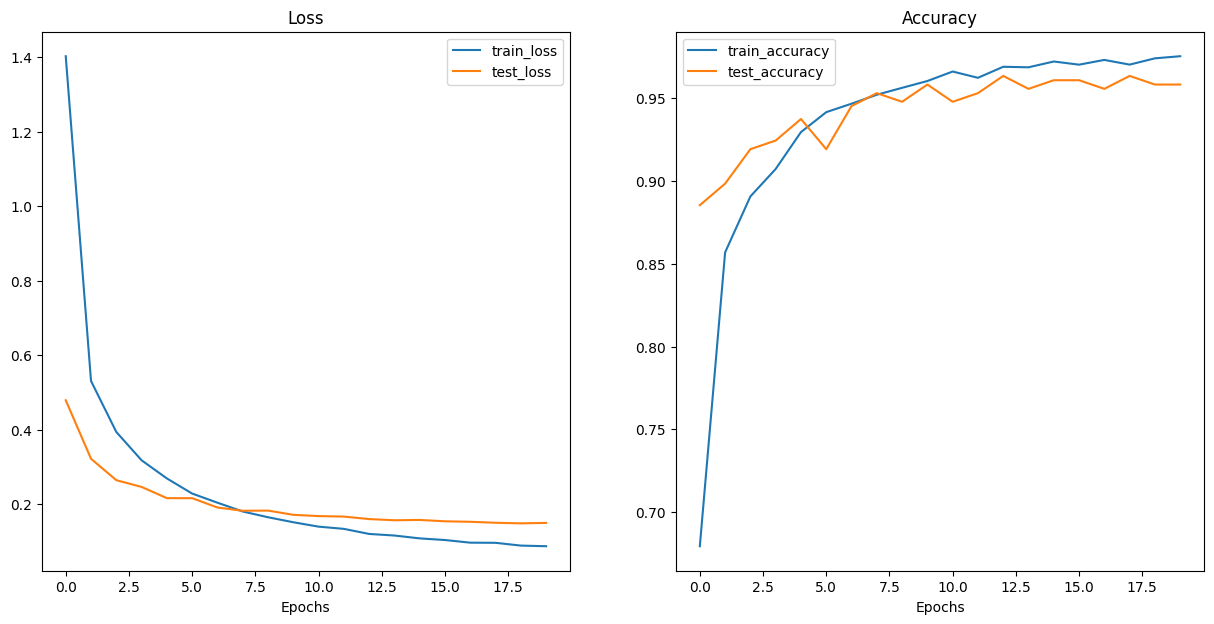

In [33]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results) 

## That's the power of transfer learning!

We managed to get outstanding results with the same model architecture, except our custom implementation was trained from scratch (worse performance) and this feature extractor model has the power of pretrained weights from ImageNet behind it.

# Let's make Prediction:

In [66]:
import torch

# Save the model
torch.save(pretrained_vit, 'pretrained_vit.pth')


CONFUSION METRICS & ROC AND CURVE ANALYSIS

In [10]:
# Load the saved model
saved_model_path = r'C:\Users\User\Desktop\VisionClassification\pretrained_vit.pth'
loaded_model = torch.load(saved_model_path)
loaded_model.to(device)
loaded_model.eval()  # Set the model to evaluation mode


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

Prediction

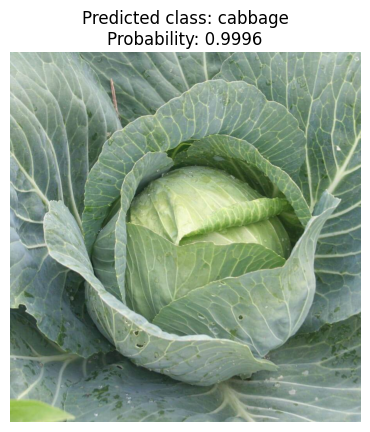

In [56]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# Load the saved model
saved_model_path = r'C:\Users\User\Desktop\VisionClassification\pretrained_vit.pth'
loaded_model = torch.load(saved_model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)
loaded_model.eval()

# Define the transformation to apply to the input image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the same size your model expects
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Load and preprocess the input image
image_path = r'C:\Users\User\Desktop\VisionClassification\dataset\test\cabbage\Image_3.jpg'
input_image = Image.open(image_path).convert("RGB")
input_tensor = preprocess(input_image)
input_tensor = input_tensor.unsqueeze(0).to(device)  # Add a batch dimension

# Make a prediction
with torch.no_grad():
    output = loaded_model(input_tensor)
    probabilities = torch.softmax(output, dim=1)  # Convert logits to probabilities
    predicted_prob, predicted_class = torch.max(probabilities, 1)

# Get the class name from the index
predicted_class_index = predicted_class.item()
predicted_class_name = class_names[predicted_class_index]

# Display the image along with the predicted class and probability
plt.imshow(input_image)
plt.title(f"Predicted class: {predicted_class_name}\nProbability: {predicted_prob.item():.4f}")
plt.axis('off')
plt.show()


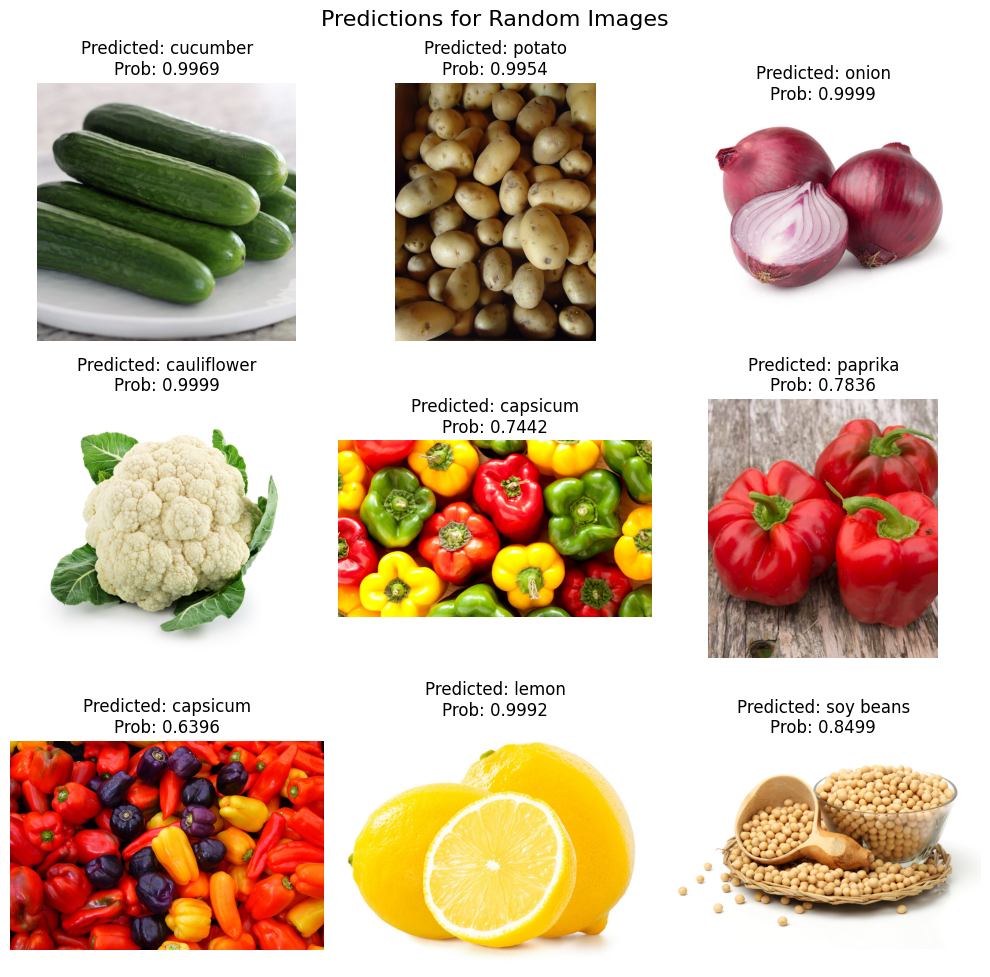

In [60]:
import torch
import random
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# Load the saved model
saved_model_path = r'C:\Users\User\Desktop\VisionClassification\pretrained_vit.pth'
loaded_model = torch.load(saved_model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)
loaded_model.eval()

# Define the transformation to apply to the input image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the same size your model expects
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Get a random image from the test dataset
num_images_to_predict = 9  # Change this to the desired number of images

# Randomly select images
selected_image_paths = random.sample(test_dataloader_pretrained.dataset.samples, num_images_to_predict)

# Create a grid to display images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle("Predictions for Random Images", fontsize=16)

# Loop through each selected image path and predict
for i, (image_path, _) in enumerate(selected_image_paths):
    row = i // 3
    col = i % 3

    # Load and preprocess the input image
    input_image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(input_image)
    input_tensor = input_tensor.unsqueeze(0).to(device)  # Add a batch dimension

    # Make a prediction
    with torch.no_grad():
        output = loaded_model(input_tensor)
        probabilities = torch.softmax(output, dim=1)  # Convert logits to probabilities
        predicted_prob, predicted_class = torch.max(probabilities, 1)

    # Get the class name from the index
    predicted_class_index = predicted_class.item()
    predicted_class_name = class_names[predicted_class_index]

    # Display the image along with the predicted class and probability
    axes[row, col].imshow(input_image)
    axes[row, col].set_title(f"Predicted: {predicted_class_name}\nProb: {predicted_prob.item():.4f}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


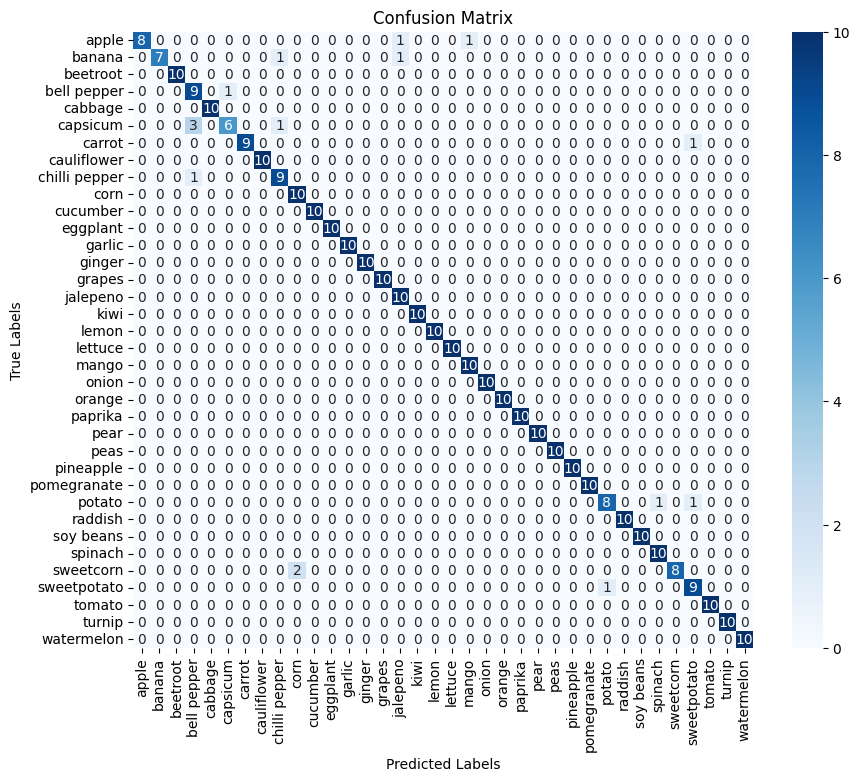

               precision    recall  f1-score   support

        apple       1.00      0.80      0.89        10
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       0.69      0.90      0.78        10
      cabbage       1.00      1.00      1.00        10
     capsicum       0.86      0.60      0.71        10
       carrot       1.00      0.90      0.95        10
  cauliflower       1.00      1.00      1.00        10
chilli pepper       0.82      0.90      0.86        10
         corn       0.83      1.00      0.91        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00        10
     jalepeno       0.83      1.00      0.91        10
         kiwi       1.00      1.00      1.00        10
        l

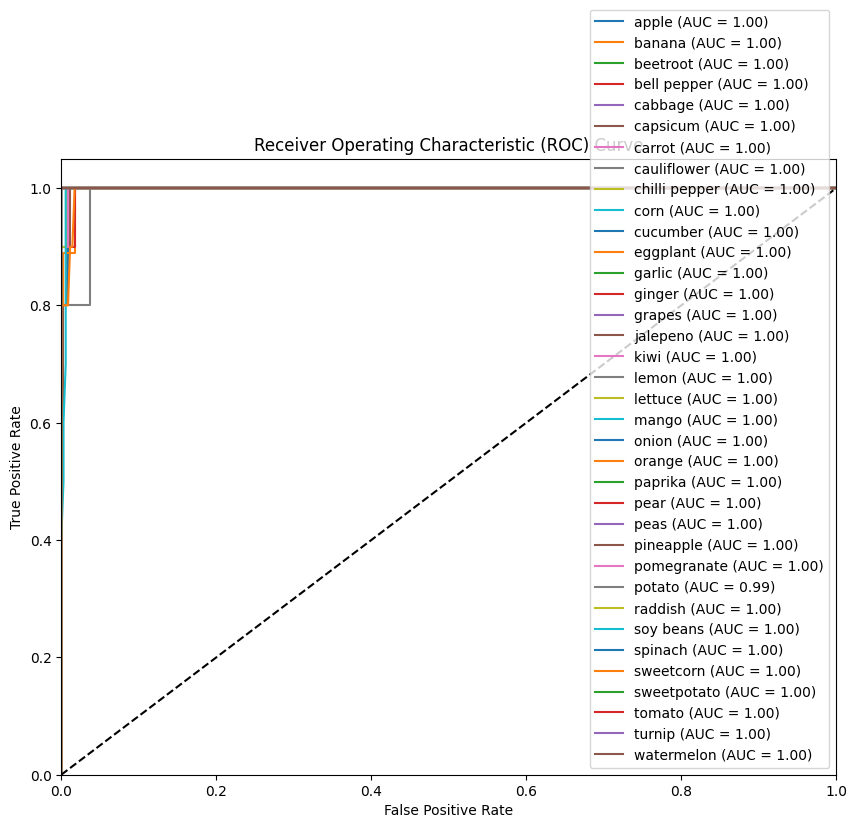

In [32]:
# Load the saved model
saved_model_path = r'C:\Users\User\Desktop\VisionClassification\pretrained_vit.pth'
loaded_model = torch.load(saved_model_path)
loaded_model.to(device)
loaded_model.eval()  # Set the model to evaluation mode

# ... (rest of your code for loading the model) ...

# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dataloader_pretrained:
        images, labels = images.to(device), labels.to(device)
        preds = loaded_model(images)
        _, predicted_labels = torch.max(preds, 1)
        
        all_preds.extend(predicted_labels.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Display confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=class_names))

# ROC and AUC Analysis
from sklearn.metrics import roc_curve, auc

# ... (previous code for predictions and labels) ...

# Calculate ROC curves and AUC scores
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve((np.array(all_labels) == i).astype(int), all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Precision Recall Curve

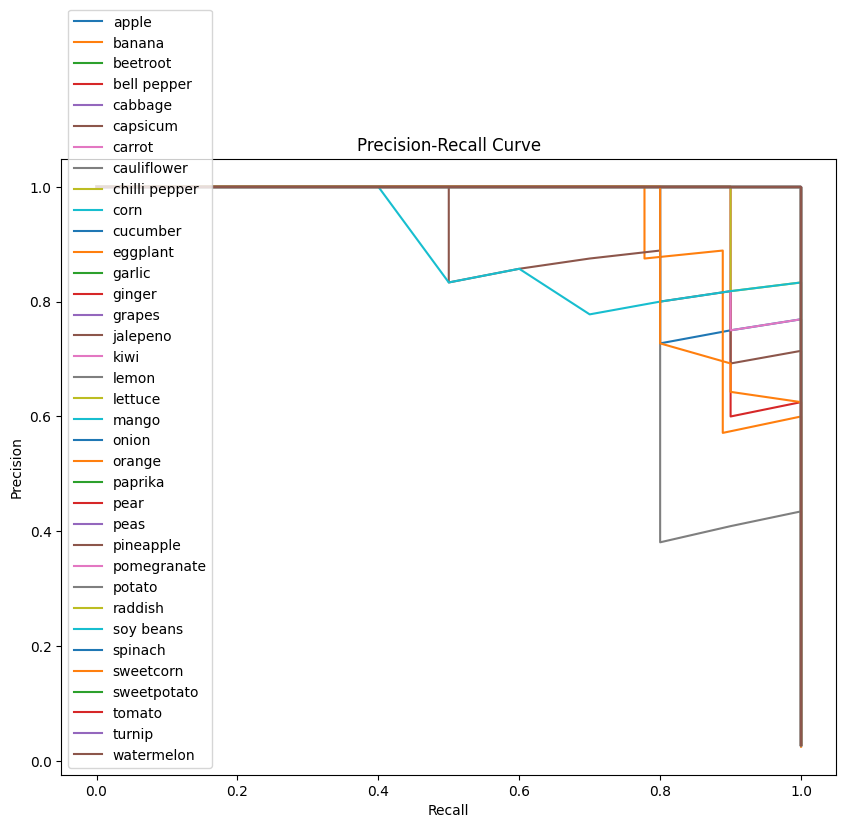

In [34]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision = dict()
recall = dict()
for i in range(len(class_names)):
    precision[i], recall[i], _ = precision_recall_curve((np.array(all_labels) == i).astype(int), all_probs[:, i])

plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(recall[i], precision[i], label=f'{class_names[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


F1 Score

F1-Score for apple: 0.8889
F1-Score for banana: 0.8750
F1-Score for beetroot: 1.0000
F1-Score for bell pepper: 0.7826
F1-Score for cabbage: 1.0000
F1-Score for capsicum: 0.7059
F1-Score for carrot: 0.9474
F1-Score for cauliflower: 1.0000
F1-Score for chilli pepper: 0.8571
F1-Score for corn: 0.9091
F1-Score for cucumber: 1.0000
F1-Score for eggplant: 1.0000
F1-Score for garlic: 1.0000
F1-Score for ginger: 1.0000
F1-Score for grapes: 1.0000
F1-Score for jalepeno: 0.9091
F1-Score for kiwi: 1.0000
F1-Score for lemon: 1.0000
F1-Score for lettuce: 1.0000
F1-Score for mango: 0.9524
F1-Score for onion: 1.0000
F1-Score for orange: 1.0000
F1-Score for paprika: 1.0000
F1-Score for pear: 1.0000
F1-Score for peas: 1.0000
F1-Score for pineapple: 1.0000
F1-Score for pomegranate: 1.0000
F1-Score for potato: 0.8421
F1-Score for raddish: 1.0000
F1-Score for soy beans: 1.0000
F1-Score for spinach: 0.9524
F1-Score for sweetcorn: 0.8889
F1-Score for sweetpotato: 0.8571
F1-Score for tomato: 1.0000
F1-Score 

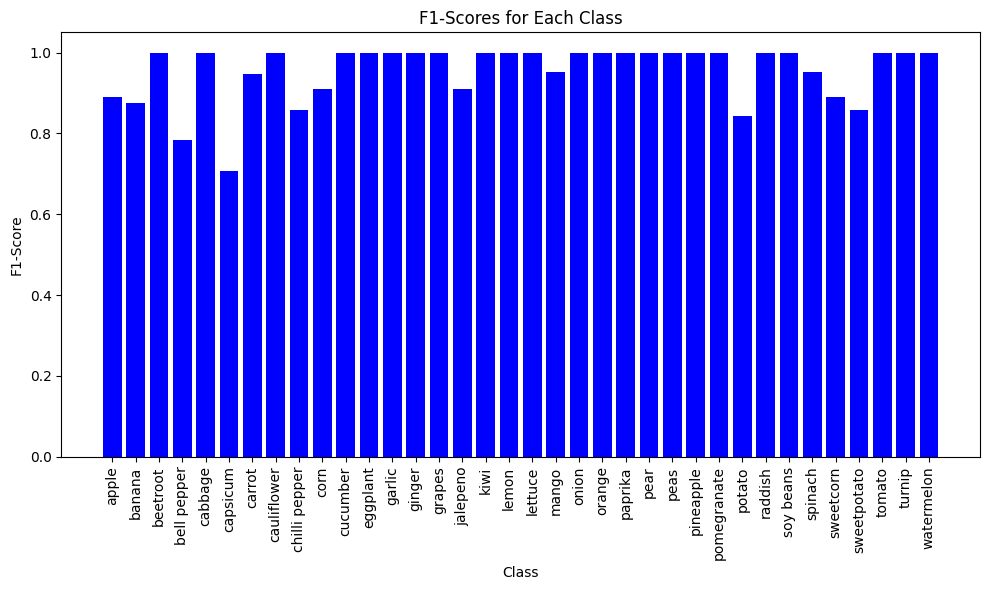

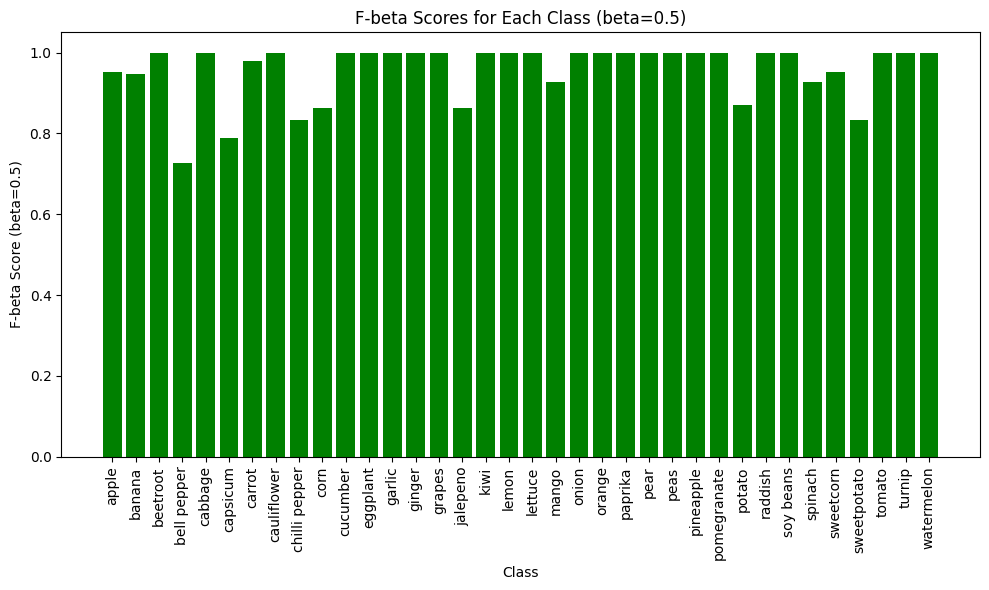

In [39]:
from sklearn.metrics import f1_score

f1_scores = []
for i in range(len(class_names)):
    f1 = f1_score((np.array(all_labels) == i).astype(int), (np.array(all_preds) == i).astype(int))
    f1_scores.append(f1)

for i, class_name in enumerate(class_names):
    print(f"F1-Score for {class_name}: {f1_scores[i]:.4f}")
    
from sklearn.metrics import fbeta_score

beta = 0.5  # Set the value of beta

f_beta_scores = []
for i in range(len(class_names)):
    f_beta = fbeta_score((np.array(all_labels) == i).astype(int), (np.array(all_preds) == i).astype(int), beta=beta)
    f_beta_scores.append(f_beta)

for i, class_name in enumerate(class_names):
    print(f"F-beta Score (beta={beta}) for {class_name}: {f_beta_scores[i]:.4f}")
    
import matplotlib.pyplot as plt
import numpy as np

# Plot F1-Scores
plt.figure(figsize=(10, 6))
plt.bar(class_names, f1_scores, color='blue')
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('F1-Scores for Each Class')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot F-beta Scores
plt.figure(figsize=(10, 6))
plt.bar(class_names, f_beta_scores, color='green')
plt.xlabel('Class')
plt.ylabel(f'F-beta Score (beta={beta})')
plt.title(f'F-beta Scores for Each Class (beta={beta})')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
